In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette='pastel')
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [2]:
def process_features(df):
    tmp = df.copy()
    tmp['date'] = pd.to_datetime(df['date'])
    tmp['month'] = tmp.date.dt.month
    tmp['year'] = tmp.date.dt.year
    tmp['most_recent_renov'] = np.maximum(tmp['yr_built'], tmp['yr_renovated'])
    tmp.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)
    return tmp.iloc[:,3:]

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
knn_train = train[['lat', 'long', 'waterfront']]
knn_test = test[['lat', 'long', 'waterfront']]
price_train = train['price']
price_test = test['price']
sqftPrice_train = train['price'] / train['sqft_living']
sqftPrice_test = test['price'] / test['sqft_living']

In [17]:
train2 = process_features(train)
test2 = process_features(test)

### Baseline Model

In [23]:
m_base = Ridge(alpha=0.1)
m_base.fit(train2, np.log(price_train))
price_pred = np.exp(m_base.predict(test2))
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 188016
Average Test Error: 0.211


### Learner 1: KNN

In [4]:
m1 = KNeighborsRegressor(n_neighbors=12)
m1.fit(knn_train, sqftPrice_train)
sqftPrice_knn_train = m1.predict(knn_train)
price_knn_train = sqftPrice_knn_train * train['sqft_living']
sqftPrice_knn_pred = m1.predict(knn_test)
price_knn_pred = sqftPrice_knn_pred * test['sqft_living']
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_knn_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_knn_pred), price_test))

Test RMSE of Sales Price: 146755
Average Test Error: 0.187


### Learner 2: Random Forest

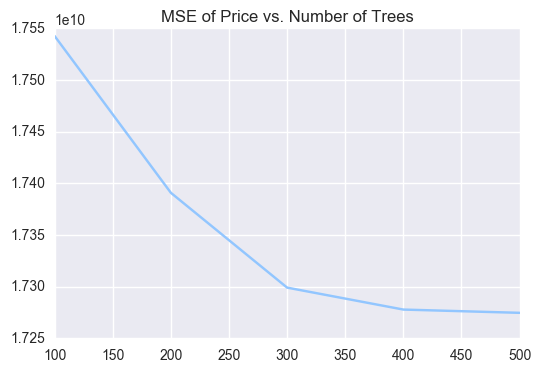

In [9]:
n_list = range(100, 600, 100)
mse_list = []
for n in n_list:
    m = RandomForestRegressor(n_estimators=n)
    mse_list.append(-np.mean(cross_val_score(m, train.iloc[:,3:], price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(n_list, mse_list)
plt.title('MSE of Price vs. Number of Trees')

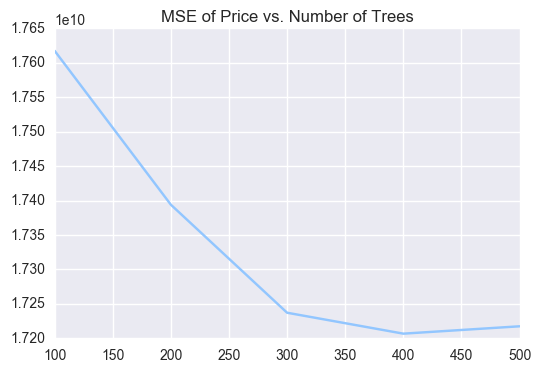

In [62]:
n_list = range(100, 600, 100)
mse_list = []
for n in n_list:
    m = RandomForestRegressor(n_estimators=n)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(n_list, mse_list)
plt.title('MSE of Price vs. Number of Trees')

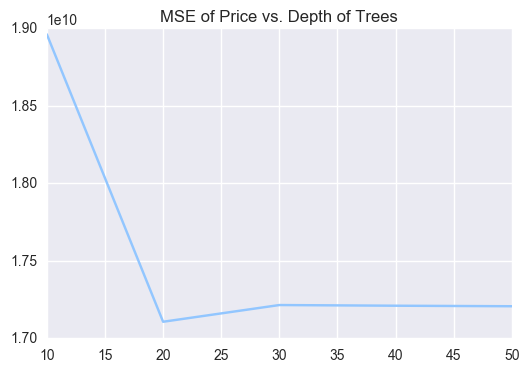

In [68]:
n = 400
d_list = range(10,60,10)
mse_list = []
for d in d_list:
    m = RandomForestRegressor(n_estimators=n, max_depth=d)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Depth of Trees')

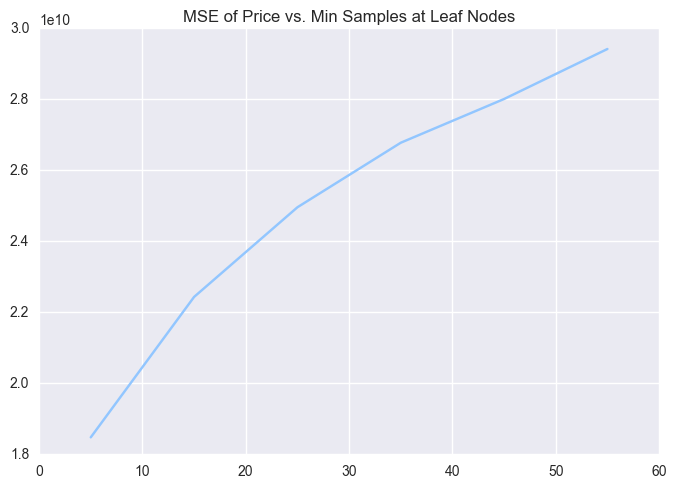

In [25]:
n = 400
d = 20
l_list = range(5,60,10)
mse_list = []
for l in l_list:
    m = RandomForestRegressor(n_estimators=n, max_depth=d, min_samples_leaf=l)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(l_list, mse_list)
plt.title('MSE of Price vs. Min Samples at Leaf Nodes')

In [6]:
m2 = RandomForestRegressor(n_estimators=400, max_depth=20, max_features='sqrt')
m2.fit(train2, price_train)
price_rf_train = m2.predict(train2)
price_rf_pred = m2.predict(test2)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_rf_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_rf_pred), price_test))

Test RMSE of Sales Price: 123323
Average Test Error: 0.135


### Gradient Boosting

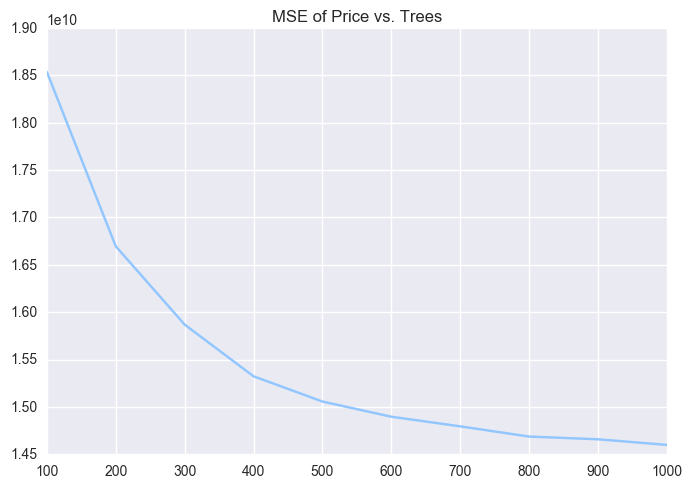

In [30]:
n = 400
d_list = range(100,1100,100)
mse_list = []
for d in d_list:
    m = GradientBoostingRegressor(n_estimators=d, learning_rate=0.1)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Trees')

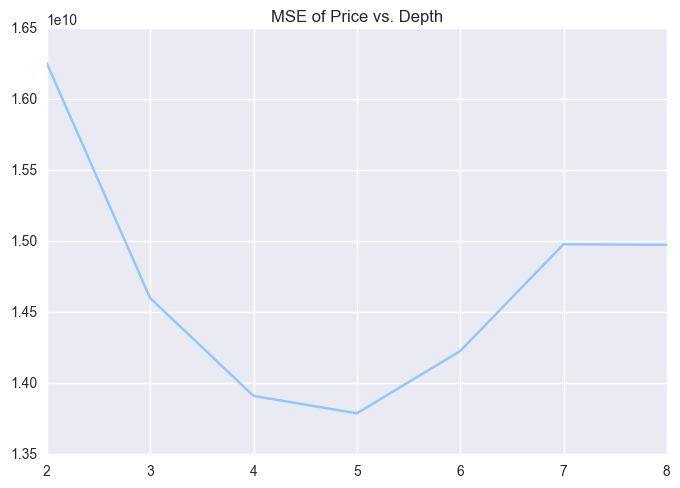

In [33]:
n = 1000
d_list = range(2,9)
mse_list = []
for d in d_list:
    m = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=d)
    mse_list.append(-np.mean(cross_val_score(m, train2, price_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))
plt.plot(d_list, mse_list)
plt.title('MSE of Price vs. Depth')

In [34]:
m3 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5)
m3.fit(train2, price_train)
price_sgb_train = m3.predict(train2)
price_sgb_pred = m3.predict(test2)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_sgb_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_sgb_pred), price_test))

Test RMSE of Sales Price: 106098
Average Test Error: 0.120


### Emsemble

#### Combine with linear regression

In [7]:
combine_train = np.stack([price_rf_train, price_knn_train], axis=1)
combine_test = np.stack([price_rf_pred, price_knn_pred], axis=1)
combiner = LinearRegression()
combiner.fit(combine_train, price_train)
price_pred = combiner.predict(combine_test)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 128930
Average Test Error: 0.137


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


#### Combine with Ridge

In [16]:
combine_train = np.column_stack((price_rf_train, price_knn_train, train2))
combine_test = np.column_stack((price_rf_pred, price_knn_pred, test2))
combiner = Ridge(alpha=1)
combiner.fit(combine_train, price_train)
price_pred = combiner.predict(combine_test)
print 'Test RMSE of Sales Price: %d' % np.sqrt(mean_squared_error(price_test, price_pred))
print 'Average Test Error: %.3f' % np.mean(np.true_divide(abs(price_test - price_pred), price_test))

Test RMSE of Sales Price: 125113
Average Test Error: 0.137
